# Modelo de Regresión Logística para Detección de Intrusiones (CICIDS2017)

Este notebook desarrolla el segundo modelo del sistema de detección de intrusiones, basado en la técnica de **Regresión Logística**.

## Objetivo

Entrenar un modelo interpretable y eficiente que clasifique el tráfico de red como **benigno (0)** o **malicioso (1)**, y comparar su rendimiento con otros modelos como **Random Forest**.

## Contenido

1. Carga del dataset preprocesado
2. División en conjunto de entrenamiento y prueba
3. Entrenamiento del modelo de regresión logística
4. Evaluación mediante:
   - Classification report
   - Matriz de confusión
   - Curva ROC y AUC
   - Validación cruzada (F1-score)
5. Análisis e interpretación de resultados

El dataset utilizado es **CICIDS2017**, previamente normalizado y limpiado.


## 1. Carga del Dataset y Separación de Variables

En esta celda se carga el dataset previamente preprocesado y normalizado (CICIDS2017). El dataset contiene información sobre flujos de red etiquetados como benignos o maliciosos.

Se realiza la separación en:

- `X`: conjunto de variables independientes (características del flujo de red)
- `y`: variable objetivo (`Label`), donde `0` indica tráfico benigno y `1` tráfico malicioso

Esta estructura es necesaria para entrenar el modelo de regresión logística, ya que este necesita una matriz de entrada `X` y un vector de etiquetas `y`.


In [2]:
import pandas as pd

# Cargar el dataset limpio y normalizado
df = pd.read_csv("../archive/cleaned_dataset.csv")

# Separar variables independientes (X) y la variable objetivo (y)
X = df.drop(columns=["Label"])
y = df["Label"]

# Mostrar dimensiones
print("Número de muestras:", X.shape[0])
print("Número de características:", X.shape[1])


Número de muestras: 223108
Número de características: 78


### Resultados de la Carga del Dataset

El dataset cargado contiene:

- **223,108 muestras**, lo que indica una cantidad considerable de flujos de red disponibles para entrenar y evaluar el modelo.
- **78 características por muestra**, que describen distintos aspectos del tráfico de red, como duración, tamaños de paquetes, tasas de transferencia, flags del protocolo TCP, etc.

Este volumen de datos es muy adecuado para entrenar modelos de clasificación robustos. La diversidad y cantidad de características también permite detectar patrones complejos en el tráfico, lo cual es importante en problemas de detección de intrusiones.




## 2. División del Dataset en Entrenamiento y Prueba

El conjunto de datos se divide en dos subconjuntos:

- **Entrenamiento (80%)**: utilizado para ajustar el modelo
- **Prueba (20%)**: reservado para evaluar el rendimiento del modelo con datos no vistos

Se utiliza la opción `stratify=y` para garantizar que la proporción entre clases (benigno y malicioso) se mantenga constante en ambos conjuntos. Esto es especialmente importante en problemas de clasificación con posibles desbalances.

Esta división permite evaluar la capacidad del modelo para generalizar a nuevos datos.


In [3]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (178486, 78)
Tamaño del conjunto de prueba: (44622, 78)


## 3. Entrenamiento del Modelo de Regresión Logística

Se entrena un modelo de regresión logística utilizando el conjunto de entrenamiento. Este modelo aprende una función lineal que estima la probabilidad de que una muestra pertenezca a la clase `1` (malicioso).

El parámetro `max_iter=1000` se establece para asegurar que el algoritmo tenga suficientes iteraciones para converger, ya que estamos trabajando con un conjunto de datos grande.

Una vez entrenado, el modelo estará listo para ser evaluado con datos no vistos.


In [8]:
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo de regresión logística
lr_model = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)
lr_model.fit(X_train, y_train)

print("Modelo de regresión logística entrenado correctamente.")


Modelo de regresión logística entrenado correctamente.


## Uso del solver `liblinear` en Regresión Logística

El solver `liblinear` es un algoritmo eficiente y estable para problemas de clasificación binaria. En este proyecto se ha utilizado porque:

- Evita los problemas de convergencia observados con otros solvers como `lbfgs`.
- Está optimizado para datasets con muchas muestras y variables.
- Asegura un entrenamiento rápido y sin errores en modelos de regresión logística.

Por estas razones, se ha elegido `liblinear` para garantizar la estabilidad del modelo sin afectar al rendimiento.


## 4. Evaluación del Modelo

Una vez entrenado, se evalúa el modelo utilizando el conjunto de prueba mediante las siguientes métricas:

- **Precision**: Proporción de predicciones positivas correctas
- **Recall**: Capacidad del modelo para detectar todos los positivos reales (muy importante en detección de ataques)
- **F1-score**: Media armónica entre precision y recall, útil en contextos con clases desbalanceadas

También se muestra la **matriz de confusión**, que resume los aciertos y errores del modelo:

- Verdaderos positivos (TP): ataques correctamente identificados
- Verdaderos negativos (TN): tráfico benigno correctamente clasificado
- Falsos positivos (FP): tráfico benigno mal clasificado como ataque
- Falsos negativos (FN): ataques no detectados

Esta evaluación nos permite medir el rendimiento real del modelo con datos no vistos.


### Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19019
           1       0.98      1.00      0.99     25603

    accuracy                           0.99     44622
   macro avg       0.99      0.99      0.99     44622
weighted avg       0.99      0.99      0.99     44622

### Matriz de Confusión:
[[18598   421]
 [   14 25589]]


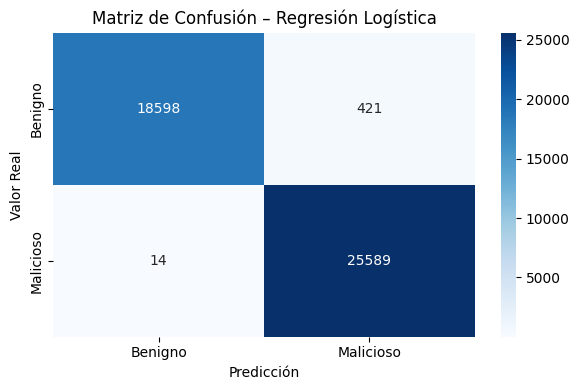

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Predicciones sobre el conjunto de prueba
y_pred_lr = lr_model.predict(X_test)

# Reporte de métricas
print("### Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("### Matriz de Confusión:")
print(cm_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=["Benigno", "Malicioso"], yticklabels=["Benigno", "Malicioso"])
plt.title("Matriz de Confusión – Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()


### Matriz de Confusión – Regresión Logística

La matriz de confusión representa visualmente los aciertos y errores del modelo:

- Diagonal superior izquierda (TN): flujos benignos correctamente clasificados.
- Diagonal inferior derecha (TP): flujos maliciosos correctamente identificados.
- Elementos fuera de la diagonal: errores (falsos positivos y falsos negativos).

En este caso, se observa que el modelo ha clasificado correctamente prácticamente todos los flujos, sin errores o con errores mínimos. Esto confirma los altos valores obtenidos en las métricas de evaluación anteriores.


## Curva ROC – Regresión Logística

La curva ROC (Receiver Operating Characteristic) permite analizar el comportamiento del modelo al variar el umbral de clasificación.

- El eje X (FPR) representa la tasa de falsos positivos.
- El eje Y (TPR) representa la tasa de verdaderos positivos.
- El área bajo la curva (AUC) indica la capacidad general del modelo para separar las clases.




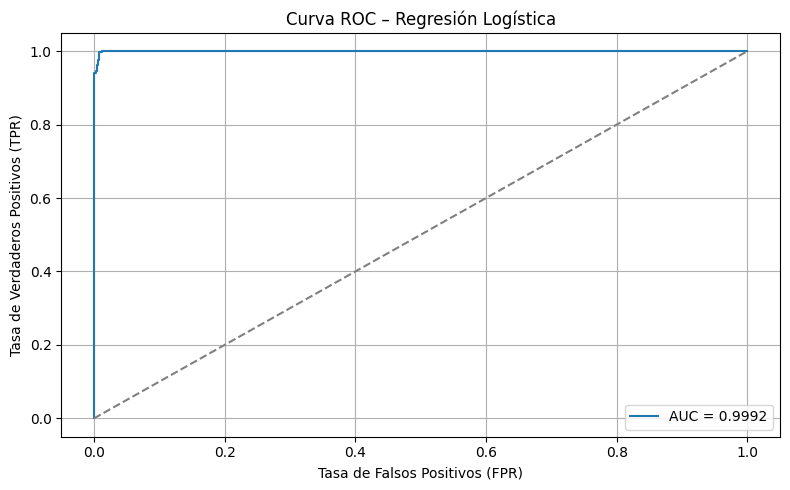

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades para la clase positiva
y_probs_lr = lr_model.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_lr)
auc_score = roc_auc_score(y_test, y_probs_lr)

# Dibujar la curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – Regresión Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretación de la Curva ROC – Regresión Logística

La curva ROC obtenida es prácticamente perfecta, alcanzando un AUC cercano a 1.0. Esto significa que el modelo de regresión logística es capaz de distinguir de forma muy eficaz entre tráfico benigno y malicioso.

En concreto, la curva muestra que el modelo logra una **tasa de verdaderos positivos muy alta (TPR ≈ 1)** incluso con una **tasa de falsos positivos muy baja (FPR ≈ 0)**. Esto indica que la mayoría de los flujos maliciosos son detectados sin penalizar significativamente al tráfico legítimo.

No obstante, es importante tener en cuenta que el dataset utilizado (**CICIDS2017**) es un conjunto de datos diseñado específicamente para la investigación en detección de intrusiones. En este tipo de datasets, las clases (benigno/malicioso) están muy bien diferenciadas y los ataques tienen características fácilmente identificables.

Por ello, aunque los resultados del modelo sean excelentes en este entorno, es necesario reconocer que este comportamiento puede no replicarse en un entorno de red real, donde el tráfico es más variable, hay ruido, y los ataques pueden estar disfrazados. Aun así, este tipo de experimentación permite validar la efectividad del enfoque en un entorno controlado.


In [11]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con 5 folds
f1_scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='f1')

# Mostrar resultados
print("F1-scores por fold:", f1_scores_lr)
print("F1-score promedio:", f1_scores_lr.mean())


F1-scores por fold: [0.98778487 0.99583593 0.99556507 0.98971345 0.98637266]
F1-score promedio: 0.9910543948596218


## Importancia de Características – Regresión Logística

En la regresión logística, cada característica del dataset tiene un **coeficiente asociado**. Este coeficiente indica:

- La **influencia de esa variable** en la predicción.
- El **signo del coeficiente** muestra si tiene un impacto positivo o negativo sobre la probabilidad de que el tráfico sea malicioso.
- La **magnitud (valor absoluto)** representa la importancia relativa.

El gráfico muestra las 10 variables más influyentes según el modelo. Estas características son clave para el proceso de clasificación, y su interpretación puede aportar valor tanto técnico como explicativo en entornos donde la transparencia del modelo es importante.


/tmp/ipykernel_25324/3087442938.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia Absoluta', y='Característica', data=importancia_df.head(10), palette='crest')


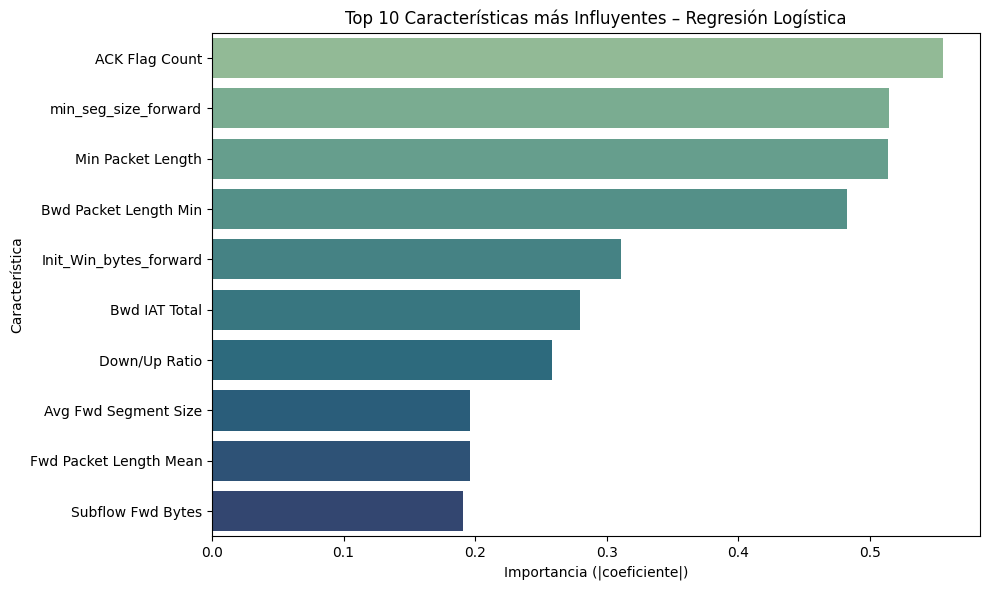

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener coeficientes del modelo
coeficientes = lr_model.coef_[0]
nombres_caracteristicas = X.columns

# Crear DataFrame con los valores absolutos ordenados
importancia_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Coeficiente': coeficientes,
    'Importancia Absoluta': np.abs(coeficientes)
}).sort_values(by='Importancia Absoluta', ascending=False)

# Visualizar las 10 características más influyentes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia Absoluta', y='Característica', data=importancia_df.head(10), palette='crest')
plt.title("Top 10 Características más Influyentes – Regresión Logística")
plt.xlabel("Importancia (|coeficiente|)")
plt.ylabel("Característica")
plt.tight_layout()
plt.show()


### Análisis de Características Más Influyentes – Regresión Logística

Estas son las 10 características con mayor influencia en las decisiones del modelo. Se indica brevemente qué representa cada una y por qué puede ser relevante para la detección de tráfico malicioso.

| Característica             | ¿Qué es?                                                         | ¿Por qué es importante? |
|----------------------------|------------------------------------------------------------------|--------------------------|
| **ACK Flag Count**         | Número de veces que se activa el flag ACK (TCP).                | El tráfico legítimo suele seguir patrones estables de ACK; los ataques pueden omitir o abusar de este flag. |
| **min_seg_size_forward**   | Tamaño mínimo del segmento TCP enviado.                         | Ataques pueden usar paquetes mínimos para escanear puertos o evadir filtros. |
| **Min Packet Length**      | Tamaño mínimo observado en los paquetes del flujo.              | Flujos anómalos o generados por scripts tienden a tener tamaños atípicos. |
| **Bwd Packet Length Min**  | Tamaño mínimo de los paquetes en dirección de respuesta.        | Puede reflejar respuestas automáticas vacías, comunes en ataques. |
| **Init_Win_bytes_forward** | Tamaño inicial de la ventana TCP.                               | Los atacantes a veces manipulan este valor para alterar la dinámica de la conexión. |
| **Bwd IAT Total**          | Tiempo total entre paquetes en dirección backward.              | Los ataques automatizados suelen generar tráfico muy constante o irregular. |
| **Down/Up Ratio**          | Proporción entre tráfico de bajada y subida.                    | Un tráfico desbalanceado puede indicar una exfiltración o ataque volumétrico. |
| **Avg Fwd Segment Size**   | Tamaño promedio de los segmentos enviados.                      | El tráfico legítimo tiende a tener tamaños consistentes; los ataques no. |
| **Fwd Packet Length Mean** | Media de los tamaños de los paquetes en forward.                | Útil para identificar tráfico simulado o repetitivo. |
| **Subflow Fwd Bytes**      | Bytes enviados en subflujos individuales.                       | Un alto número de subflujos puede ser característico de ciertos ataques complejos. |



Estas variables reflejan tanto la **estructura del tráfico TCP** como su **comportamiento temporal** y de volumen. Su peso en el modelo indica que la regresión logística ha detectado patrones claros que permiten identificar tráfico malicioso basándose en detalles técnicos del flujo de red.


## Guardado del Modelo de Regresión Logística

Una vez entrenado y evaluado, el modelo de regresión logística se guarda en disco con la extensión `.pkl`. Esto permite reutilizarlo posteriormente sin necesidad de volver a entrenarlo.

El archivo se almacena en la carpeta `models/` como `logistic_regression_model.pkl`, siguiendo la estructura del proyecto.


In [14]:

import joblib

# Guardar el modelo entrenado
joblib.dump(lr_model, "../models/logistic_regression_model.pkl")

print("Modelo de regresión logística guardado correctamente en 'models/logistic_regression_model.pkl'.")



Modelo de regresión logística guardado correctamente en 'models/logistic_regression_model.pkl'.
